# CT4101 Assignment 1 Notebook

- Logistic Regression (tune C, penalty)
- SVM RBF (tune C, gamma)

In [6]:
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
print(sys.version)
FIGS = Path("../figures"); FIGS.mkdir(exist_ok=True)  # folder for report images

3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]


In [7]:
DATA = Path("../data")
train = pd.read_csv(DATA / "wildfires_training.csv")
test  = pd.read_csv(DATA / "wildfires_test.csv")

print(train.shape, test.shape)
train.head()  # just to eyeball columns


(154, 10) (50, 10)


,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


In [8]:
target = "fire"  # target column 
y_train = (train[target].astype(str).str.lower() == "yes").astype(int)
y_test  = (test[target].astype(str).str.lower()  == "yes").astype(int)
X_train = train.drop(columns=[target])
X_test  = test.drop(columns=[target])

print("Class balance (train):"); print(y_train.value_counts())


Class balance (train):
fire
1    79
0    75
Name: count, dtype: int64


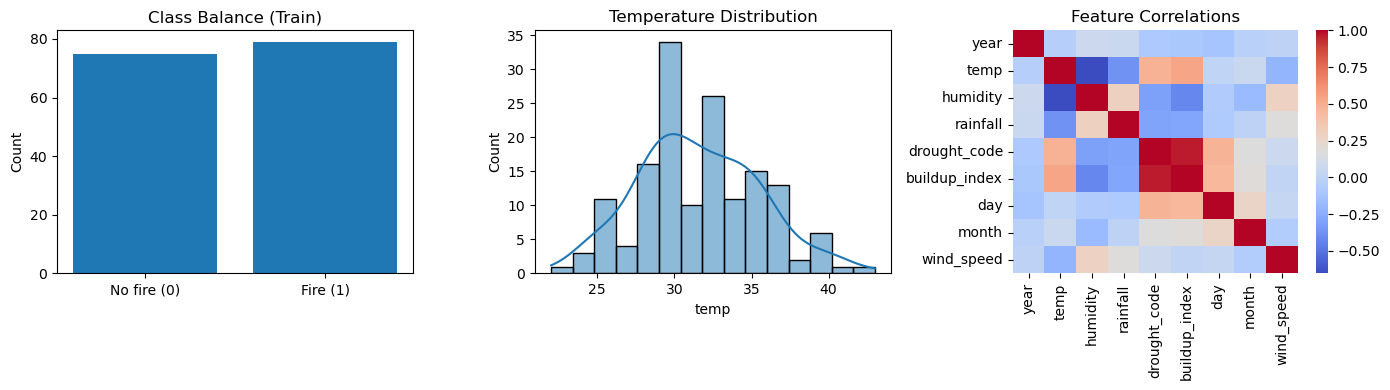

Saved: ..\figures\Figure_3_dataset_visualisation.png


In [9]:
# --- Figure 3: Data Preprocessing & Visualisation (EDA) ---
# Place this cell AFTER the class-balance print, BEFORE scaling/training

# try seaborn for nicer plots; fall back to matplotlib if not installed
try:
    import seaborn as sns
    use_sns = True
except Exception:
    use_sns = False

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build a DataFrame for plotting (unscaled features are fine for EDA)
df_vis = X_train.copy()
df_vis["fire"] = y_train

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1) Class balance (train)
counts = y_train.value_counts().sort_index()  # 0 then 1
axes[0].bar(["No fire (0)", "Fire (1)"], counts.values)
axes[0].set_title("Class Balance (Train)")
axes[0].set_ylabel("Count")

# 2) Example feature distribution (temperature)
if "temp" in df_vis.columns:
    if use_sns:
        sns.histplot(df_vis["temp"], bins=15, kde=True, ax=axes[1])
    else:
        axes[1].hist(df_vis["temp"], bins=15, alpha=0.9)
    axes[1].set_title("Temperature Distribution")
    axes[1].set_xlabel("temp")
else:
    # fallback: use first numeric column
    numcol = df_vis.select_dtypes(include=np.number).columns[0]
    axes[1].hist(df_vis[numcol], bins=15, alpha=0.9)
    axes[1].set_title(f"Distribution: {numcol}")
    axes[1].set_xlabel(numcol)

# 3) Feature correlation heatmap
corr = df_vis.drop(columns=["fire"]).corr(numeric_only=True)
if use_sns:
    sns.heatmap(corr, cmap="coolwarm", ax=axes[2])
else:
    im = axes[2].imshow(corr.values, cmap="coolwarm")
    axes[2].set_xticks(range(len(corr.columns)))
    axes[2].set_xticklabels(corr.columns, rotation=90)
    axes[2].set_yticks(range(len(corr.columns)))
    axes[2].set_yticklabels(corr.columns)
    fig.colorbar(im, ax=axes[2])
axes[2].set_title("Feature Correlations")

plt.tight_layout()
plt.savefig(FIGS / "Figure_3_dataset_visualisation.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", FIGS / "Figure_3_dataset_visualisation.png")


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


LR baseline accuracy: 0.86


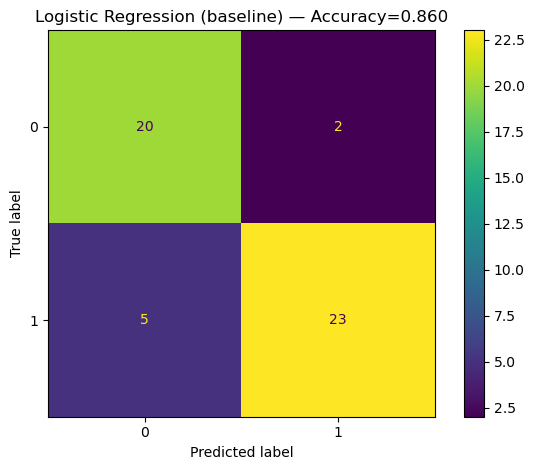

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

lr = LogisticRegression(max_iter=500, penalty="l2", C=1.0)
lr.fit(X_train_s, y_train)

y_pred = lr.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print("LR baseline accuracy:", acc)

# Confusion matrix image 
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Logistic Regression (baseline) — Accuracy={acc:.3f}")
plt.tight_layout()
plt.savefig(FIGS / "cm_lr_baseline.png", dpi=200)
plt.show()

# Saving classification report table for later
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).to_csv(
    FIGS / "lr_baseline_classification_report.csv"
)


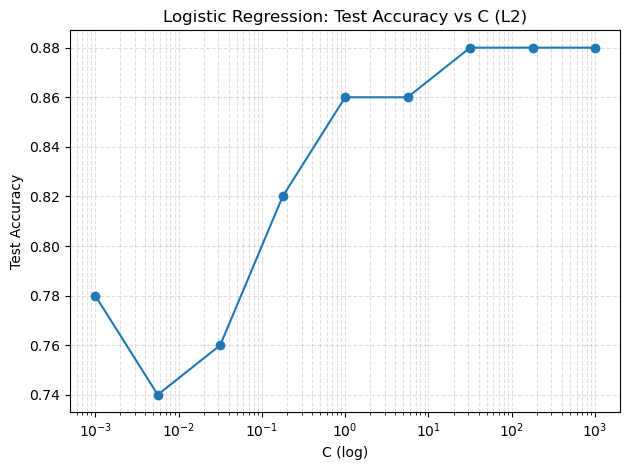

In [12]:
Cvals = np.logspace(-3, 3, 9)
rows = []
for C in Cvals:
    m = LogisticRegression(max_iter=500, penalty="l2", C=C)
    m.fit(X_train_s, y_train)
    rows.append((C, accuracy_score(y_test, m.predict(X_test_s))))
res = pd.DataFrame(rows, columns=["C","test_acc"])
res.to_csv(FIGS/"lr_sweep_c_l2.csv", index=False)

plt.figure()
plt.semilogx(res["C"], res["test_acc"], marker="o")
plt.xlabel("C (log)"); plt.ylabel("Test Accuracy")
plt.title("Logistic Regression: Test Accuracy vs C (L2)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(FIGS/"lr_sweep_c_l2.png", dpi=200)
plt.show()
